In [1]:
import sys

#Due to leftoevererrors in Nathan's python installation, some cleaning up occurs here
#sys.path.append("./code/")
#sys.path.remove('/usr/local/lib/python2.7/site-packages') 


import matplotlib.pyplot as plt
%matplotlib inline
import copy
import datetime
import pickle
import gzip
import os,glob
import time
import numpy as np
import pandas as pd
#sys.path

import regex as re
import datetime
import math

from IPython.core.display import display,HTML
display(HTML("<style>.container { width:100% !important; }</style>"))  # to make the notebook use the entire width of the browser


In [2]:
# This code is the MongoConnection class from the Amaral lab LabTools folder.

from __future__ import print_function, unicode_literals
import sys
from pymongo import MongoClient


class MongoConnection(object):
    def __init__(self, cxnSettings, **kwargs):
        self.settings = cxnSettings
        self.mongoURI = self._constructURI()
        self.connect(**kwargs)
        self.ensure_index()

    def _constructURI(self):
        '''
        Construct the mongo URI
        '''
        mongoURI = 'mongodb://'
        #User/password handling
        if 'user'in self.settings and 'password' in self.settings:
            mongoURI += self.settings['user'] + ':' + self.settings['password']
            mongoURI += '@'
        elif 'user' in self.settings:
            print('Missing password for given user, proceeding without either')
        elif 'password' in self.settings:
            print('Missing user for given passord, proceeding without either')
        #Host and port
        try:
            mongoURI += self.settings['host'] + ':'
        except KeyError:
            print('Missing the hostname. Cannot connect without host')
            sys.exit()
        try:
            mongoURI += str(self.settings['port'])
        except KeyError:
            print('Missing the port. Substituting default port of 27017')
            mongoURI += str('27017')
        return mongoURI

    def connect(self, **kwargs):
        '''
        Establish the connection, database, and collection
        '''
        self.connection = MongoClient(self.mongoURI, **kwargs)
        #########
        try:
            self.db = self.connection[self.settings['db']]
        except KeyError:
            print("Must specify a database as a 'db' key in the settings file")
            sys.exit()
        #########
        try:
            self.collection = self.db[self.settings['collection']]
        except KeyError:
            print('Should have a collection.', end='')
            print('Starting a collection in database', end='')
            print(' for current connection as test.')
            self.collection = self.db['test']

    def tearDown(self):
        '''
        Closes the connection
        '''
        self.connection.close()

    def ensure_index(self):
        '''
        Ensures the connection has all given indexes.
        indexes: list of (`key`, `direction`) pairs.
            See docs.mongodb.org/manual/core/indexes/ for possible `direction`
            values.
        '''
        if 'indexes' in self.settings:
            for index in self.settings['indexes']:
                self.collection.ensure_index(index[0], **index[1])

In [10]:
def retrieve_trajectory(ut, plos_uts):
    # Retrieve a citation trajectory for a single reference UT. This version collects -all- WoS citations for a given UT,
    # PLOS or not, so this one takes a lot more time, but shows the underlaying shape of the citation profile.
    # Requires inputting the list of all plos UTs ('paper_UT' column in the plos dataframe)
    count = 0
    cite_dates = {}
    
    doc = papers_con.collection.find_one({"UT":ut})
    if 'citations' in doc:
        for ref_ut in doc['citations']:
            count+=1
            ref = papers_con.collection.find_one({"UT":ref_ut})
            year = float('nan')
            date = float('nan')
            plos_flag = False
            if ref:
                if 'issue' in ref:
                    if 'PY' in ref['issue']:
                        year = ref['issue']['PY']
                    if 'PD' in ref['issue']:
                        date = ref['issue']['PD']
                    if ref_ut in plos_uts:
                        plos_flag = True
                    
            if count%1000==0:
                print(count)   
            cite_dates[ref_ut] = [date, year, plos_flag]

    return cite_dates


def retrieve_multiple_trajectories(ut_list, plos_uts):
    # Retrieve multiple trajectories for all reference UTs in ut_list. Returns a nested dictionary
    # {Reference_UT_1: {Citation_UT_1: [Month, Year], ...}}
    trajectories = {}
    for ut in ut_list:
        print(ut)
        cite_dates = retrieve_trajectory(ut, plos_uts)
        trajectories[ut] = cite_dates
    return trajectories


def retrieve_trajectory_plos_only(ut, plos_uts):
    # Retrieve a citation trajectory for a single reference UT. This version collects only PLOS citations, so it's much faster
    # Requires inputting the list of all plos UTs ('paper_UT' column in the plos dataframe)

    count = 0
    cite_dates = {}
    if ut in plos_uts:
        doc = papers_con.collection.find_one({"UT":ut})
        if 'citations' in doc:
            for ref_ut in doc['citations']:
                count+=1
                ref = papers_con.collection.find_one({"UT":ref_ut})
                year = float('nan')
                date = float('nan')
                plos_flag = False
                if ref:
                    if 'issue' in ref:
                        if 'PY' in ref['issue']:
                            year = ref['issue']['PY']
                        if 'PD' in ref['issue']:
                            date = ref['issue']['PD']
                        if ref_ut in plos_uts:
                            plos_flag = True
                if count%1000==0:
                    print(count)   
                cite_dates[ref_ut] = [date, year, plos_flag]

    return cite_dates


def retrieve_multiple_trajectories_plos_only(ut_list, plos_uts):
    # Retrieve multiple trajectories for all reference UTs in ut_list. Returns a nested dictionary
    # {Reference_UT_1: {Citation_UT_1: [Month, Year], ...}}

    trajectories = {}
    for ut in ut_list:
        print(ut)
        cite_dates = retrieve_trajectory_plos_only(ut, plos_uts)
        trajectories[ut] = cite_dates
    return trajectories

In [12]:
def datetime_filler_traj(traj_dict):
    # Generate a new dictionary from a trajectory dictionary with datetime objects. Includes the plos_flag value
    

    numeric = re.compile('[0-9]+')
    alpha = re.compile('[A-Za-z]+')
    month_dict = {'JAN':1, 'FEB': 2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN': 6, 
                  'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT':10, 'NOV': 11, 'DEC': 12,
                 'SPR': 3, 'SUM': 6, 'FAL': 9, 'WIN': 12}
    formatted_traj_dict = {}
    
    for ref_ut in traj_dict:
        formatted_traj_dict[ref_ut] = {}
        for cite_ut in traj_dict[ref_ut]:
            date = traj_dict[ref_ut][cite_ut][0]
            year = traj_dict[ref_ut][cite_ut][1]
            plos_flag = traj_dict[ref_ut][cite_ut][2]
            
            date_field = []

            if type(date) == str:
                
                for i in re.findall(alpha, date):
                    date_field.append(i)
                for i in re.findall(numeric, date):
                    date_field.append(i)
                
                if len(date_field) > 2: # No weirdness here, only 2 values max for date field
                    print(date_field)
                
                if len(date_field[0])==1: # There's a single date that is just '0'. Likely a database error/nan
                    print(date_field)

                    
            else:
                date_field = ['JUNE', '15']
                
            month = -1
            day = -1
            
            if date_field[0] in month_dict:
                month = month_dict[date_field[0]]
                if len(date_field)==2:
                    if len(date_field[1])<3:
                        day = int(date_field[1])
            
                        
            if not math.isnan(year):
                if month != -1:
                    if day != -1:
                        dt = datetime.datetime(year, month, day)
                    else:
                        dt = datetime.datetime(year, month, 15)
                    
                else:
                    dt = datetime.datetime(year, 6, 15)


            else:
                dt = -1
            
            formatted_traj_dict[ref_ut][cite_ut] = [dt, plos_flag]

    return formatted_traj_dict

In [13]:
merged_papers_settings = {
    "host": "chicago.chem-eng.northwestern.edu",
    "port": "27017",
    "db": "web_of_science_aux",
    "collection": "merged_papers",
    "user": "mongoreader",
    "password": "emptycoffeecup"
}
issues_settings = {
    "host": "chicago.chem-eng.northwestern.edu",
    "port": "27017",
    "db": "web_of_science_aux",
    "collection": "issues",
    "user": "mongoreader",
    "password": "emptycoffeecup"
}
journal_settings = {
    "host": "chicago.chem-eng.northwestern.edu",
    "port": "27017",
    "db": "web_of_science_aux",
    "collection": "journals",
    "user": "mongoreader",
    "password": "emptycoffeecup"
}
papers_con = MongoConnection(merged_papers_settings)
issue_con = MongoConnection(issues_settings)
journal_con = MongoConnection(journal_settings)

'/home/staff/julia/at_Northwestern/In_Text_Citations/In-Text-Citations-New/notebooks'

In [14]:
def section_regex_parser(ref_df):
# Using regular expressions to sort sections. Reach a concensus on section identification by scanning both section_title and section_title_alt
    import regex as re

    sect_index_dict = {'intro': 0, 'methods': 1, 'results': 2, 'disc': 3, 'res_disc':4, 'concl':5, 'mixed':6, 'na':7}

    intro_re = re.compile(r'(intro)')
    method_re = re.compile(r'(method)')
    results_re = re.compile(r'(results)')
    disc_re = re.compile(r'(disc)')
    concl_re = re.compile(r'(conclu)')
    backgr_re = re.compile(r'(backgr)')
    mater_re = re.compile(r'(mater)')
    count = 0
    judgement = []

    for i in range(len(ref_df)):
        count += 1
        if count%100000 == 0:
            print(count)
        sect = ref_df.iloc[i]['section_title']
        sect_alt = ref_df.iloc[i]['section_title_alt']
        sect_tag = -1
        sect_alt_tag = -1
        sect_final = -1

        if sect == None:
            sect_tag = 'na'
        else:
            if re.search(intro_re, sect.lower()) or re.search(backgr_re, sect.lower()):
                sect_tag = 'intro'

            elif re.search(method_re,sect.lower()) or re.search(mater_re, sect.lower()):
                if re.search(results_re, sect.lower()):
                    sect_tag = 'mixed'

                elif re.search(disc_re, sect.lower()):
                    sect_tag = 'mixed'

                else:
                    sect_tag = 'methods'

            elif re.search(results_re, sect.lower()):
                if re.search(disc_re, sect.lower()):
                    sect_tag = 'res_disc'
                else:
                    sect_tag = 'results'

            elif re.search(disc_re, sect.lower()):
                sect_tag = 'disc'

            elif re.search(concl_re, sect.lower()):
                sect_tag = 'concl'

            else:
                sect_tag = 'na'



        if sect_alt == None:
            sect_alt_tag = 'na'
        else:
            if re.search(intro_re, sect_alt.lower()) or re.search(backgr_re, sect_alt.lower()):
                sect_alt_tag = 'intro'

            elif re.search(method_re, sect_alt.lower()) or re.search(mater_re, sect_alt.lower()):
                if re.search(results_re, sect_alt.lower()):
                    sect_alt_tag = 'mixed'

                elif re.search(disc_re, sect_alt.lower()):
                    sect_alt_tag = 'mixed'

                else:
                    sect_alt_tag = 'methods'

            elif re.search(results_re, sect_alt.lower()):
                if re.search(disc_re, sect_alt.lower()):
                    sect_alt_tag = 'res_disc'
                else:
                    sect_alt_tag = 'results'

            elif re.search(disc_re, sect_alt.lower()):
                sect_alt_tag = 'disc'

            elif re.search(concl_re, sect_alt.lower()):
                sect_alt_tag = 'concl'

            else:
                sect_alt_tag = 'na'



        if sect_tag == sect_alt_tag: # Confident on label
            sect_final = sect_tag
            #ref_df.iloc[i]['regex_sect_index'] = sect_index_dict[sect_tag]

        else:
            if sect_tag == 'na':
                sect_final = sect_alt_tag
                #ref_df.iloc[i]['regex_sect_index'] = sect_index_dict[sect_alt_tag]
            elif sect_alt_tag == 'na':
                sect_final = sect_tag

            elif sect_tag == 'mixed':
                sect_final = sect_alt_tag

            elif sect_alt_tag == 'mixed':
                sect_final = sect_tag

            elif sect_alt_tag == 'concl': # Conclusion is a plos-based standard that includes discussion/results and discussion
                sect_final = sect_tag
            else:
                sect_final = sect_alt_tag

        judgement.append(sect_final)
    return judgement
        #ref_df.iloc[i]['regex_sect_index'] = sect_index_dict[sect_final]

In [15]:
def filter_df_zero_citations(df_pap_,df_ref_,df_pap_ref_):

    list_ref_ut_ = list(df_ref_[\
                              (df_ref_['cite_count']>0)\
                             ].index.values)
    df_ref_sel_ = df_ref_[df_ref_.index.isin(list_ref_ut_)]
    df_pap_ref_sel_ = df_pap_ref_[df_pap_ref_['reference_UT'].isin(list_ref_ut_)]
    ## identify the remaining pap-uts and cut the df_pap dataframe
    list_pap_ut_ = df_pap_ref_sel_['paper_UT'].drop_duplicates().tolist()
    df_pap_sel_ = df_pap_[df_pap_.index.isin(list_pap_ut_)]

    ## in case we want to get rid again of the 'unique_occurrences'-column
    # df_ref_sel_.drop('occurrences_unique', axis=1, inplace=True)
    return df_pap_sel_,df_ref_sel_,df_pap_ref_sel_

def filter_df_plos(df_pap_,df_ref_,df_pap_ref_, y1_,y2_, list_pap_art_type_, list_pap_field_ = None):
    '''filter our three dataframes
        - publication-year-interval >=y1_ <= y2_
        - article-type: list_pap_art_type_

    TODO:
        - scientific field 
        - journal (plosone,plosbio, ....)
    '''
    ## identify paper-uts that satisfy the constraints
    if list_pap_field_ == None: ## no contraint no field
        list_pap_ut_ = list(df_pap_[\
                              (df_pap_['plos_pub_year']>=y1_)&(df_pap_['plos_pub_year']<=y2_)\
                                &(df_pap_['plos_article_type'].isin(list_pap_art_type_))\
                             ].index.values)
    else: ## constraint on field
        ## create list-field as string
        x_tmp = df_pap_['plos_field'].values
        y_tmp = [str(h) for h in x_tmp]
        df_pap_.loc[:,'plos_field_str'] = y_tmp
        field_sel_str_ = '|'.join(list_pap_field_)
        list_pap_ut_ = list(df_pap_[\
                      (df_pap_['plos_pub_year']>=y1_)&(df_pap_['plos_pub_year']<=y2_)\
                        &(df_pap_['plos_article_type'].isin(list_pap_art_type_))\
                        &(df_pap_['plos_field_str'].str.contains(field_sel_str_))\
                     ].index.values)

    ## cut the df_pap dataframe
    df_pap_sel_ = df_pap_[df_pap_.index.isin(list_pap_ut_)]
    try:
        df_pap_sel_.drop('plos_field_str', axis=1, inplace=True)
    except ValueError:
        pass

    ## cut the df_pap_ref dataframe
    df_pap_ref_sel_ = df_pap_ref_[df_pap_ref_['paper_UT'].isin(list_pap_ut_)]

    ## identify the remaining ref-uts and cut the df_ref dataframe
    list_ref_ut_ = df_pap_ref_sel_['reference_UT'].drop_duplicates().tolist()
    df_ref_sel_ = df_ref_[df_ref_.index.isin(list_ref_ut_)]
    return df_pap_sel_,df_ref_sel_,df_pap_ref_sel_

def filter_df_ref(df_pap_,df_ref_,df_pap_ref_, n_occ_min_,n_occ_max_, y1_,y2_, list_ref_art_type_, list_ref_field_ = None):
    '''filter our three dataframes
        - number of unique occurrences in plos-paers: n_thresh
        - publication-year-interval >=y1_ <= y2_
        - article-type: list_pap_art_type_

    TODO:
        - scientific field 
    '''
    ## create a new column in df_ref with unique number of occurrences
    df_tmp = df_pap_ref_[['paper_UT', 'reference_UT']].drop_duplicates() # remove multi-occurence of the same ref in the same paper
    x_ = df_tmp.groupby(['reference_UT'])['reference_UT'].value_counts()
    x_ut_ = [h[0] for h in x_.index.tolist()]
    x_series_tmp = pd.Series(data=x_.values,index=x_ut_)
    df_ref_.loc[:,'occurrences_unique'] = x_series_tmp

    ## filter ref-uts and cut the df_ref dataframe
    if list_ref_field_ == None: ## no contraint no field

        list_ref_ut_ = list(df_ref_[\
                                  (df_ref_['occurrences_unique']>=n_occ_min_)&(df_ref_['occurrences_unique']<=n_occ_max_)\
                                  &(df_ref_['ref_pub_year']>=y1_)&(df_ref_['ref_pub_year']<=y2_)\
                                  &(df_ref_['ref_article_type'].isin(list_ref_art_type_))\
                                 ].index.values)

    else: ## constraint on field
        ## create list-field as string
        x_tmp = df_ref_['ref_field'].values
        y_tmp = [str(h) for h in x_tmp]
        df_ref_.loc[:,'ref_field_str'] = y_tmp
        field_sel_str_ = '|'.join(list_ref_field_)
        list_ref_ut_ = list(df_ref_[\
                          (df_ref_['occurrences_unique']>=n_occ_min_)&(df_ref_['occurrences_unique']<=n_occ_max_)\
                          &(df_ref_['ref_pub_year']>=y1_)&(df_ref_['ref_pub_year']<=y2_)\
                          &(df_ref_['ref_article_type'].isin(list_ref_art_type_))\
                          &(df_ref_['ref_field_str'].str.contains(field_sel_str_))\
                         ].index.values)

    df_ref_sel_ = df_ref_[df_ref_.index.isin(list_ref_ut_)]

    ## cut the df_pap dataframe
    try:
        df_ref_sel_.drop('ref_field_str', axis=1, inplace=True)
    except ValueError:
        pass


    ## cut the df_pap_ref dataframe
    df_pap_ref_sel_ = df_pap_ref_[df_pap_ref_['reference_UT'].isin(list_ref_ut_)]

    ## identify the remaining pap-uts and cut the df_pap dataframe
    list_pap_ut_ = df_pap_ref_sel_['paper_UT'].drop_duplicates().tolist()
    df_pap_sel_ = df_pap_[df_pap_.index.isin(list_pap_ut_)]

    ## in case we want to get rid again of the 'unique_occurrences'-column
    # df_ref_sel_.drop('occurrences_unique', axis=1, inplace=True)
    return df_pap_sel_,df_ref_sel_,df_pap_ref_sel_

In [16]:
# Load up current dataframe

ref_df_min = pickle.load(open('../data/ref_dataframe_min.pkl', 'rb'))
plos_df = pickle.load(open('../data/plos_paper_dataframe.pkl', 'rb'))
cite_df = pickle.load(open('../data/citation_dataframe.pkl', 'rb'))
#ref_df = pd.concat([ref_df_p1, ref_df_p2])
#suppl_dict= pickle.load(open('../suppl_dict.txt', 'rb'))

In [17]:
judgement = section_regex_parser(ref_df)
judgement_2 = []
sect_index_dict = {'intro': 0, 'methods': 1, 'results': 2, 'disc': 3, 'res_disc':4, 'concl':5, 'mixed':6, 'na':7}
for i in judgement:
    judgement_2.append(sect_index_dict[i])
ref_df['regex_sect_index'] = judgement_2

NameError: name 'ref_df' is not defined

In [ ]:
ref_df_min.loc[:,'paper_UT'] = ref_df_min.index

In [107]:
# ## dont need for now


# from collections import Counter
# ## for the plos-papers
# x = plos_df['plos_field'].values
# list_fields_pap = []
# for h in x:
#     if isinstance(h, (list, tuple)):
#         list_fields_pap += h
#     else:
#         list_fields_pap += [h]
        
# c_fields_pap = Counter(list_fields_pap)
# for field_,n_field_ in c_fields_pap.most_common(10):
#     print(field_,n_field_)

D RO MULTIDISCIPLINARY SCIENCES 124637
D CU BIOLOGY 42796
D TI PARASITOLOGY 5259
D YU TROPICAL MEDICINE 3546
D KM GENETICS & HEREDITY 2300
D QU MICROBIOLOGY 1713
D ZE VIROLOGY 1713
D CO BIOCHEMICAL RESEARCH METHODS 1410
D MC MATHEMATICAL & COMPUTATIONAL BIOLOGY 1410
D CQ BIOCHEMISTRY & MOLECULAR BIOLOGY 1022


In [ ]:
## filtering plos-articles
pap_pub_year_min = 2000
pap_pub_year_max = 2010
pap_art_type = ['@ Article','L Letter','K Article','N Note']

list_pap_field = None ## if you want to keep all fields
# list_pap_field = ['D CU BIOLOGY']

## filtering reference-article
n_thresh = 10
n_max = 100000
ref_pub_year_min = 1900
ref_pub_year_max = 2000
list_ref_art_type = ['@ Article','L Letter','K Article','N Note']
list_ref_field = None ## if you want to keep all fields
# list_ref_field = ['D CQ BIOCHEMISTRY & MOLECULAR BIOLOGY']

In [ ]:
df_pap, df_ref, df_pap_ref = filter_df_plos(plos_df, cite_df, ref_df,\
                                            pap_pub_year_min, pap_pub_year_max,\
                                            pap_art_type,\
                                           list_pap_field_ = list_pap_field\
                                           ) 

In [ ]:
df_pap

In [ ]:
df_pap, df_ref, df_pap_ref = filter_df_ref(df_pap, df_ref, df_pap_ref,\
                                           n_thresh, n_max,\
                                           ref_pub_year_min, ref_pub_year_max,\
                                           ref_art_type,\
                                          list_ref_field_ = list_ref_field\
                                          )

In [ ]:
print(len(df_pap_ref))
print(len(df_pap_ref['reference_UT'].unique()))
print(np.mean(df_pap_ref['cite_count']))

In [156]:
list(df_pap_ref['reference_UT'].unique())

['000223658400031',
 '000187449400012',
 '000234969600020',
 '000256693400024',
 '000259205600007',
 '000247077500026',
 '000247573900013',
 '000245075900012',
 '000235742700012',
 '000245271200015',
 '000183514400006',
 '000224785900047',
 '000225020200048',
 '000259501300029',
 '000259501300030',
 '000183832900117',
 '000088581500029',
 '000245243100007',
 '000174058300015',
 '000185192300049',
 '000089451500013',
 '000249737400015',
 '000236941800053',
 '000222662400031',
 '000223866800025',
 '000232660500046',
 '000245813400056',
 '000250230400038',
 '000188079000117',
 '000236755900009',
 '000222706400045',
 '000246922700010',
 '000236350400036',
 '000235554900070',
 '000260674000039',
 '000220409900006',
 '000220065300064',
 '000179530000051',
 '000232231900043',
 '000232199900010',
 '000183790600007',
 '000180397600047',
 '000184183900032',
 '000207583500010',
 '000261534200004',
 '000261170500031',
 '000261215900017',
 '000184485400068',
 '000175000300043',
 '000241523400054',


In [ ]:
result = ref_df_min.join(cite_df, on='reference_UT')
ref_df = result.join(plos_df, on='paper_UT')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
326394


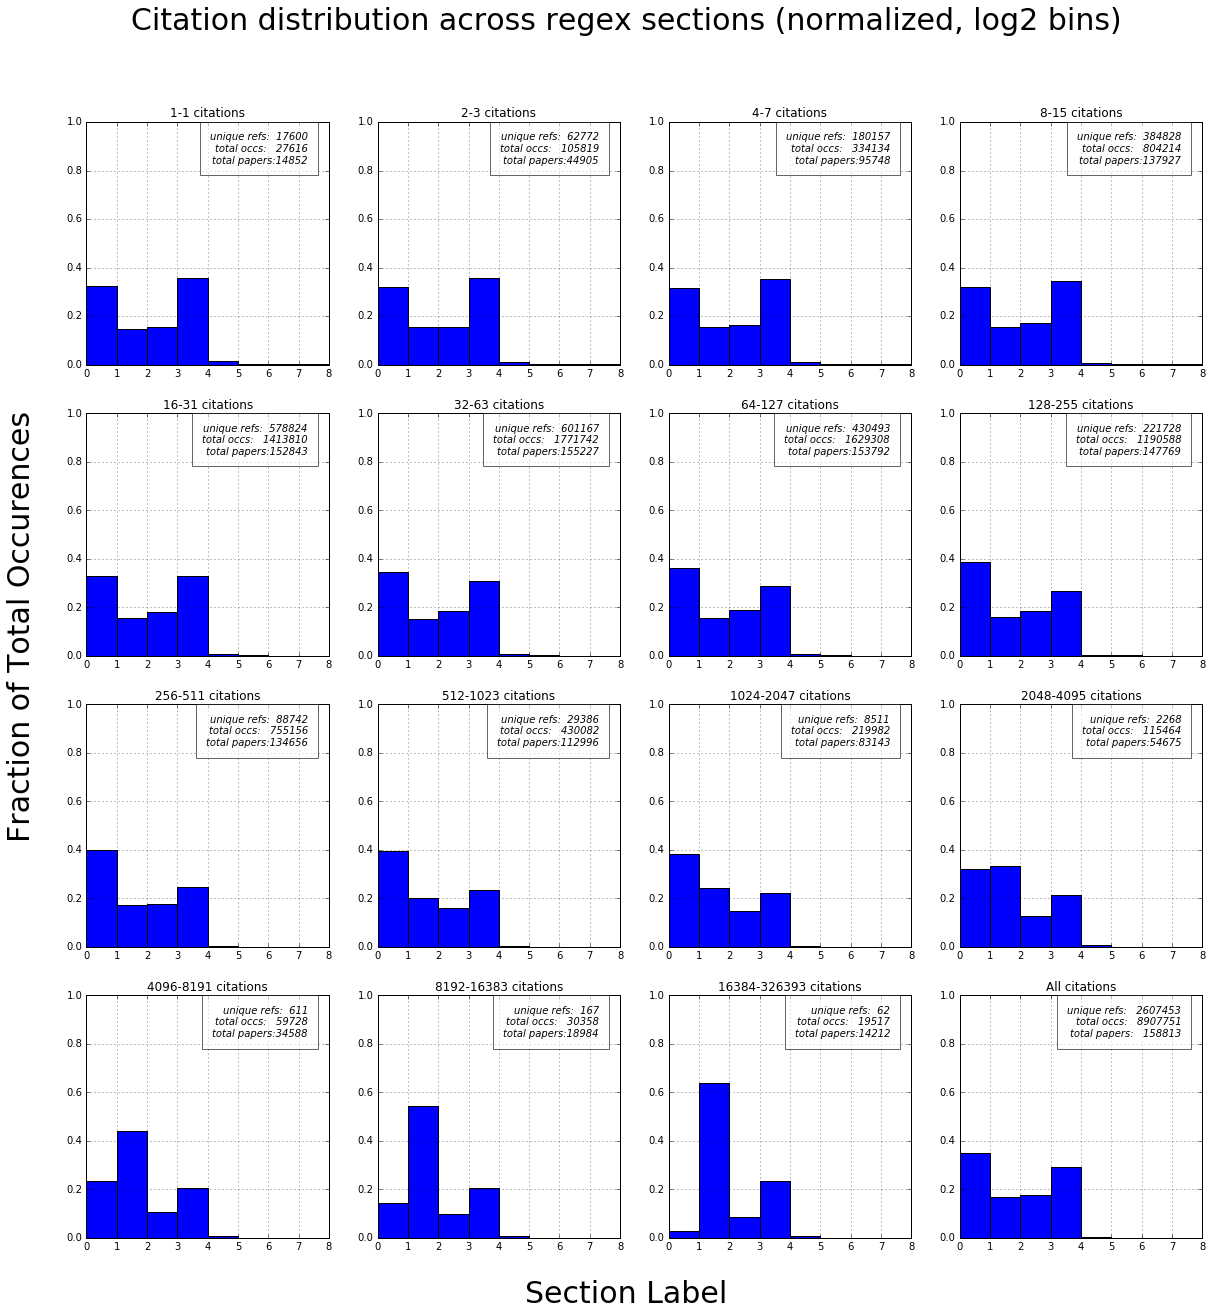

In [38]:
# ## dont need for now

# # Non-time-filtered regex-based exploration
# import numpy as np
# i=0
# #k = np.log2(i)
# bin_points = []
# while i<16:
#     k = 2**i
#     i+=1
#     bin_points.append(k)
# bin_points


# fig = plt.figure(figsize=(20,20))
# fig.suptitle('Citation distribution across regex sections (normalized, log2 bins)', size=30)
# bin_num = 8
# subplot_num = 1
# hist_list_raw = []
# #hist_list = np.array([])
# hist_list = []

# for i in range(len(bin_points)-1):
#     print(subplot_num)
#     #print(i)
#     if i == len(bin_points)-2:
#         upper_bound = int(max(ref_df['cite_count'])+1)
#         print(upper_bound)
#     else:
#         upper_bound = bin_points[i+1]
#         #print('asdfasdf')
        

#     cite_count_log_list = ref_df.loc[ref_df['cite_count'].isin(range(bin_points[i], upper_bound))]
#     title_text = str(bin_points[i]) + '-' + str(upper_bound-1) + ' citations'
#     unique_refs = len(cite_count_log_list['reference_UT'].unique())
#     unique_papers = len(cite_count_log_list['paper_UT'].unique())
#     total_occs = len(cite_count_log_list)
    
#     ax = fig.add_subplot(4,4,subplot_num)
    
    
#     hist1, bins1 = np.histogram(cite_count_log_list['sect_index'], bins= bin_num, range=[0,8])
#     hist_list_raw.append(hist1)
#     widths1 = np.diff(bins1)
#     hist1 = hist1/float(len(cite_count_log_list))
#     hist_list.append(hist1)
#     #hist_list = np.append(hist_list, hist1, axis=1)
#     ax.bar(bins1[:-1], hist1, widths1)
    
#     ax.title.set_text(title_text)
    
#     subtext1 = 'unique refs:  ' + str(unique_refs)
#     subtext2 = 'total occs:   ' + str(total_occs)
#     subtext3 = 'total papers:' + str(unique_papers)


#     ax.text(7.3, 0.83, subtext1 + '\n' + subtext2 + '\n' + subtext3, style='italic', horizontalalignment='right',
#         bbox={'facecolor':'white', 'alpha':0.6, 'pad':10})

#     ax.grid()
#     ax.set_ylim([0,1])
#     ax.set_xlim([0,7])
#     ax.set_xticks([0,1,2,3,4,5,6,7,8])
#     subplot_num +=1
    

# # Plotting the distribution for all papers    
# cite_count_all = ref_df.loc[(ref_df['cite_count']>=0)]
# title_text = 'All citations'
# unique_refs = len(cite_count_all['reference_UT'].unique())
# unique_papers = len(cite_count_all['paper_UT'].unique())
# total_occs = len(cite_count_all)

# ax = fig.add_subplot(4,4,subplot_num)
# hist1, bins1 = np.histogram(cite_count_all['sect_index'], bins= bin_num, range=[0,8])
# hist_all_raw = hist1
# widths1 = np.diff(bins1)
# hist1 = hist1/float(len(cite_count_all))
# hist_all = hist1
# ax.bar(bins1[:-1], hist1, widths1)
# ax.title.set_text(title_text)
# subtext1 = 'unique refs:   ' + str(unique_refs)
# subtext2 = 'total occs:   ' + str(total_occs)
# subtext3 = 'total papers:   ' + str(unique_papers)

# ax.text(7.3, 0.83, subtext1 + '\n' + subtext2 + '\n' + subtext3, style='italic', horizontalalignment='right',
#     bbox={'facecolor':'white', 'alpha':0.6, 'pad':10})
# ax.grid()
# ax.set_ylim([0,1])
# ax.set_xlim([0,7])
# ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],['i','m','r','d','rd','c','mx','na',''])


# fig.text(0.5, 0.08, 'Section Label', ha='center', size = 30)
# fig.text(0.07, 0.55, 'Fraction of Total Occurences', va='center', rotation='vertical', size = 30)

In [97]:
mid_cites = ref_df.loc[ref_df['cite_count'].isin(range(100, 110))]

In [98]:
len(mid_cites['reference_UT'].unique())

52408

In [15]:
high_cites = ref_df[ref_df['cite_count']>=16384]

In [58]:
a = ref_df[ref_df['paper_UT'] == '000271022300001']

In [85]:
len(high_cites['paper_UT'].unique())

14212

In [29]:
len(high_cites['reference_UT'].unique())

62

In [31]:
len(ref_df['paper_UT'].unique())

159057

In [32]:
len(ref_df['reference_UT'].unique())

2607458

In [33]:
any_cites = ref_df[ref_df['cite_count']>=1]

In [34]:
len(any_cites['reference_UT'].unique())

2607316

In [39]:
any_cites['paper_UT'].unique()[0]

'000324515600133'

In [41]:
doc = papers_con.collection.find_one({"UT":'000324515600133'})
doc

{'AB': 'Obstructive nephropathy is the most common presentation of urothelial carcinoma. The role of the urine in the obstructed kidney namely "hydronephrotic urine" in urothelial carcinoma has not been extensively explored. This study aims to evaluate whether hydronephrotic urine in the obstructed kidney could promote urothelial carcinoma. The hydronephrotic urine was collected from the obstructed kidneys of Sprague-Dawley rats induced by different periods of unilateral ureteral obstruction (UUO). By the inhibition of LY294002 and PD184352, we confirm that hydronephrotic urine promotes urothelial carcinoma cell (T24) and immortalized normal urothelial cells (E6) proliferation, migration and invasion in a dose-dependent manner through the activation of the mTORC2-AKT and ERK signaling pathways. Hydronephrotic urine also increases the expression of cyclin-D2, cyclin-B and CDK2. It also decreases the expression of p27 and p21 in both urothelial carcinoma cells and normal urothelial cells

In [ ]:
test_traj = retrieve_trajectory('000089825700038')

In [ ]:
test_traj

In [59]:
doc = papers_con.collection.find_one({"UT":'000181970800023'})
doc

{'AB': 'Several years ago it was discovered that plant transformation with a transcribed sense transgene could shut down the expression of a homologous endogenous gene. Moreover, it was shown that the introduction into the cell of dsRNA (double-stranded RNA) containing nucleotide sequence complementary to an mRNA sequence causes selective degradation of the latter and thus silencing of a specific gene. This phenomenon, called RNA interference (RNAi) was demonstrated to be present in almost all eukaryotic organisms. RNAi is also capable of silencing transposons in germ line cells and fighting RNA virus infection. Enzymes involved in this process exhibit high homology across species. Some of these enzymes are involved in other cellular processes, for instance developmental timing, suggesting strong interconnections between RNAi and other metabolic pathways. RNAi is probably an ancient mechanism that evolved to protect eukaryotic cells against invasive forms of nucleic acids.',
 'AU': [{'

In [204]:
filtered_ref_uts = list(df_pap_ref['reference_UT'].unique()[0:10])
filtered_trajs = retrieve_multiple_trajectories(filtered_ref_uts, all_plos)

000223658400031
0
000187449400012
0
000234969600020
0
000256693400024
0
000259205600007
0
000247077500026
0
000247573900013
0
000245075900012
0
000235742700012
0
000245271200015
0


In [186]:
test_traj_dict = datetime_filler_traj(filtered_trajs)

In [187]:
test_traj_dict

{'000187449400012': {'000279019700003': [datetime.datetime(2010, 6, 15, 0, 0),
   False],
  '000382413200005': [datetime.datetime(2016, 9, 15, 0, 0), False],
  '000255355900029': [datetime.datetime(2008, 4, 15, 0, 0), False],
  '000260148900008': [datetime.datetime(2008, 9, 26, 0, 0), False],
  '000345558100114': [datetime.datetime(2014, 11, 3, 0, 0), True],
  '000272478800021': [datetime.datetime(2009, 12, 1, 0, 0), False],
  '000300193200012': [datetime.datetime(2012, 2, 15, 0, 0), False],
  '000280672100009': [datetime.datetime(2010, 7, 15, 0, 0), False],
  '000257826300006': [datetime.datetime(2008, 7, 15, 0, 0), False],
  '000257648500016': [datetime.datetime(2008, 7, 15, 0, 0), False],
  '000260693500001': [datetime.datetime(2008, 10, 15, 0, 0), False],
  '000309310600007': [datetime.datetime(2012, 9, 15, 0, 0), False],
  '000230809200006': [datetime.datetime(2005, 1, 15, 0, 0), False],
  '000244942400014': [datetime.datetime(2007, 3, 15, 0, 0), False],
  '000286925500022': [date

In [229]:
test_traj_dict['000187449400012']

{'000279019700003': [datetime.datetime(2010, 6, 15, 0, 0), False],
 '000382413200005': [datetime.datetime(2016, 9, 15, 0, 0), False],
 '000255355900029': [datetime.datetime(2008, 4, 15, 0, 0), False],
 '000260148900008': [datetime.datetime(2008, 9, 26, 0, 0), False],
 '000345558100114': [datetime.datetime(2014, 11, 3, 0, 0), True],
 '000272478800021': [datetime.datetime(2009, 12, 1, 0, 0), False],
 '000300193200012': [datetime.datetime(2012, 2, 15, 0, 0), False],
 '000280672100009': [datetime.datetime(2010, 7, 15, 0, 0), False],
 '000257826300006': [datetime.datetime(2008, 7, 15, 0, 0), False],
 '000257648500016': [datetime.datetime(2008, 7, 15, 0, 0), False],
 '000260693500001': [datetime.datetime(2008, 10, 15, 0, 0), False],
 '000309310600007': [datetime.datetime(2012, 9, 15, 0, 0), False],
 '000230809200006': [datetime.datetime(2005, 1, 15, 0, 0), False],
 '000244942400014': [datetime.datetime(2007, 3, 15, 0, 0), False],
 '000286925500022': [datetime.datetime(2011, 2, 3, 0, 0), Fals

In [240]:
sorted(range(len(dates)), key=lambda k: dates[k])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


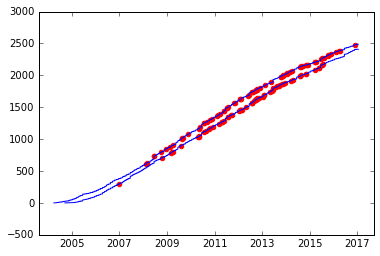

In [281]:
for paper in test_traj_dict:
    dates = []
    count = []
    plos_dates = []
    plos_count = []
    for index, cite in enumerate(test_traj_dict[paper]):
        #print(type(test_traj_dict[paper][cite][0]))
        if type(test_traj_dict[paper][cite][0]) != int:
            dates.append(test_traj_dict[paper][cite][0])#if test_traj_dict[paper][cite][1] == True:    
            count.append(index)
            if test_traj_dict[paper][cite][1] == True:
                #plos_dates.append(test_traj_dict[paper][cite][0])#if test_traj_dict[paper][cite][1] == True:    
                plos_count.append(index)
                
    sorted_ind = sorted(range(len(dates)), key=lambda k: dates[k])
    plos_dates = [dates[x] for x in plos_count]
    plos_inds = [sorted_ind.index(i) for i in plos_count]

    #print(plos_dates)
    dates.sort()
    #sorted(range(len(plos_dates)), key=lambda k: plos_dates[k])
    #plos_dates.sort()
    plt.plot(dates, count, color = 'b')
    
    plt.scatter(plos_dates, plos_inds, color='r')
    break


In [265]:
dates[0,5,10]

TypeError: list indices must be integers or slices, not tuple

In [100]:
all_plos = ref_df['paper_UT'].unique()
mid_cite_ref_uts = mid_cites['reference_UT'].unique()[0:10]
mid_cites_trajs = retrieve_multiple_trajectories(mid_cite_ref_uts, all_plos)

000312649800013
0
000313598500007
0
000251143700003
0
000244396300011
0
000240028900008
0
000168445600006
0
000075418500008
0
000171979000013
0
000300634900018
0
000165834700003
0


In [101]:
mid_cites_trajs

{'000075418500008': {'000076464500009': ['OCT', 1998, False],
  '000078797600001': ['MAR 1', 1999, False],
  '000080041700007': ['APR 19', 1999, False],
  '000083280600003': ['NOV', 1999, False],
  '000084250600005': ['DEC', 1999, False],
  '000085249200001': ['FEB 10', 2000, False],
  '000087258900009': [nan, 1999, False],
  '000089023700005': ['AUG 24', 2000, False],
  '000089037000013': ['SEP 4', 2000, False],
  '000089251200007': ['SEP', 2000, False],
  '000165108300047': ['NOV-DEC', 2000, False],
  '000166648100033': ['JAN 22', 2001, False],
  '000168469800006': ['MAY', 2001, False],
  '000169805600034': ['JUL 23', 2001, False],
  '000171470700012': ['OCT 11', 2001, False],
  '000172033200007': ['DEC 20', 2001, False],
  '000173357100033': ['JAN 17', 2002, False],
  '000174383700017': ['MAR 1', 2002, False],
  '000174865400035': ['MAY', 2002, False],
  '000175169000040': ['APR 19', 2002, False],
  '000178126500032': ['OCT 15', 2002, False],
  '000179042800008': ['NOV 7', 2002, Fal

In [104]:
ref_df.loc[:,'paper_UT'] = ref_.index

,paper_UT,reference_UT,reference_rank,occurence,section_title,section_title_alt,paper_char_pos,paper_word_pos,sect_index,sect_char_pos,...,ref_article_type,ref_field,paper_cite_count,total_refs,paper_char_total,paper_word_total,plos_pub_date,plos_pub_year,plos_article_type,plos_field
0,000324515600133,A1995QY75100004,1,1,Introduction,introduction,139,21,0,139,...,@ Article,D ZA UROLOGY & NEPHROLOGY,2,37,21733,3780,SEP 4,2013.0,@ Article,D RO MULTIDISCIPLINARY SCIENCES
1,000324515600133,A1995QY75100004,1,2,Discussion,discussion,16829,2992,3,494,...,@ Article,D ZA UROLOGY & NEPHROLOGY,2,37,21733,3780,SEP 4,2013.0,@ Article,D RO MULTIDISCIPLINARY SCIENCES
2,000324515600133,A1995QY75100004,1,3,Discussion,discussion,17257,3057,3,922,...,@ Article,D ZA UROLOGY & NEPHROLOGY,2,37,21733,3780,SEP 4,2013.0,@ Article,D RO MULTIDISCIPLINARY SCIENCES
3,000324515600133,000222499800017,2,1,Introduction,introduction,266,42,0,266,...,@ Article,D ZA UROLOGY & NEPHROLOGY,2,37,21733,3780,SEP 4,2013.0,@ Article,D RO MULTIDISCIPLINARY SCIENCES
4,000324515600133,000222499800017,2,2,Introduction,introduction,444,73,0,444,...,@ Article,D ZA UROLOGY & NEPHROLOGY,2,37,21733,3780,SEP 4,2013.0,@ Article,D RO MULTIDISCIPLINARY SCIENCES
5,000324515600133,000222499800017,2,3,Discussion,discussion,16830,2993,3,495,...,@ Article,D ZA UROLOGY & NEPHROLOGY,2,37,21733,3780,SEP 4,2013.0,@ Article,D RO MULTIDISCIPLINARY SCIENCES
6,000324515600133,000222499800017,2,4,Discussion,discussion,17110,3035,3,775,...,@ Article,D ZA UROLOGY & NEPHROLOGY,2,37,21733,3780,SEP 4,2013.0,@ Article,D RO MULTIDISCIPLINARY SCIENCES
7,000324515600133,000222499800017,2,5,Discussion,discussion,17258,3058,3,923,...,@ Article,D ZA UROLOGY & NEPHROLOGY,2,37,21733,3780,SEP 4,2013.0,@ Article,D RO MULTIDISCIPLINARY SCIENCES
8,000324515600133,000263911400006,3,1,Introduction,introduction,142,22,0,142,...,@ Article,"[D YP TRANSPLANTATION, D YA SURGERY]",2,37,21733,3780,SEP 4,2013.0,@ Article,D RO MULTIDISCIPLINARY SCIENCES
9,000324515600133,000263911400006,3,2,Introduction,introduction,445,74,0,445,...,@ Article,"[D YP TRANSPLANTATION, D YA SURGERY]",2,37,21733,3780,SEP 4,2013.0,@ Article,D RO MULTIDISCIPLINARY SCIENCES
